In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import scikitplot as skplt

## RFM analysis

In [3]:
retail = pd.read_csv('retail_clean.csv')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d/%m/%Y %H:%M")
retail['date'] = retail['InvoiceDate'].dt.strftime('%Y-%m-%d')
retail['date'] = pd.to_datetime(retail['date'])
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2009-12-01


In [4]:
max_date = retail['date'].max()
max_date

Timestamp('2011-12-09 00:00:00')

In [5]:
### recency
customer_recency = retail.groupby(by = ['Customer ID']).agg(last_purchase_date = ('date', 'max')).reset_index()
customer_recency['recency'] = max_date - customer_recency['last_purchase_date']
customer_recency['recency'] = customer_recency['recency'].astype('str').str.replace(' days','').astype('int')
customer_recency['rank_recency'] = customer_recency['recency'].rank()

In [6]:
### frequency
customer_frequency = retail.groupby(by = ['Customer ID']).agg(frequency = ('date', 'count')).reset_index()
customer_frequency['rank_frequency'] = customer_frequency['frequency'].rank(ascending = False)

In [7]:
### monetary value
customer_monetary_value = retail.groupby(by = ['Customer ID', 'Invoice']).agg(revenue = ('Revenue', 'sum')).reset_index()
customer_monetary_value = customer_monetary_value.groupby(by = ['Customer ID']).agg(average_revenue = ('revenue', 'mean')).reset_index()
customer_monetary_value['rank_average_revenue'] = customer_monetary_value['average_revenue'].rank()

In [8]:
### merge data
all_data = pd.merge(left = customer_recency, right = customer_frequency, how = 'inner', on = 'Customer ID')
all_data = pd.merge(left = all_data, right = customer_monetary_value, how = 'inner', on = 'Customer ID')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Customer ID           5881 non-null   int64         
 1   last_purchase_date    5881 non-null   datetime64[ns]
 2   recency               5881 non-null   int32         
 3   rank_recency          5881 non-null   float64       
 4   frequency             5881 non-null   int64         
 5   rank_frequency        5881 non-null   float64       
 6   average_revenue       5881 non-null   float64       
 7   rank_average_revenue  5881 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2)
memory usage: 344.7 KB


In [9]:
### using percentile to assign integer value
bins = [0, 0.35, 0.75, 1]
names = [1, 2, 3]

percentile_recency = all_data['rank_recency'].quantile(bins)
percentile_frequency = all_data['rank_frequency'].quantile(bins)
percentile_revenue = all_data['rank_average_revenue'].quantile(bins)

final = pd.DataFrame(all_data['Customer ID'])
final['recency'] = pd.cut(all_data['rank_recency'], bins = percentile_recency, labels = names, include_lowest = True, right = True).astype(int)
final['frequency'] = pd.cut(all_data['rank_frequency'], bins = percentile_frequency, labels = names, include_lowest = True, right = True).astype(int)
final['monetary_value'] = pd.cut(all_data['rank_average_revenue'], bins = percentile_revenue, labels = names, include_lowest = True, right = True).astype(int)
final['final_ranking'] = final['recency'] + final['frequency'] + final['monetary_value']

In [10]:
final

,Customer ID,recency,frequency,monetary_value,final_ranking
0,12346,2,2,3,7
1,12347,1,1,3,5
2,12348,2,2,2,6
3,12349,1,1,3,5
4,12350,2,3,2,7
...,...,...,...,...,...
5876,18283,1,1,1,3
5877,18284,3,2,3,8
5878,18285,3,3,3,9
5879,18286,3,2,3,8


<Axes: xlabel='final_ranking', ylabel='count'>

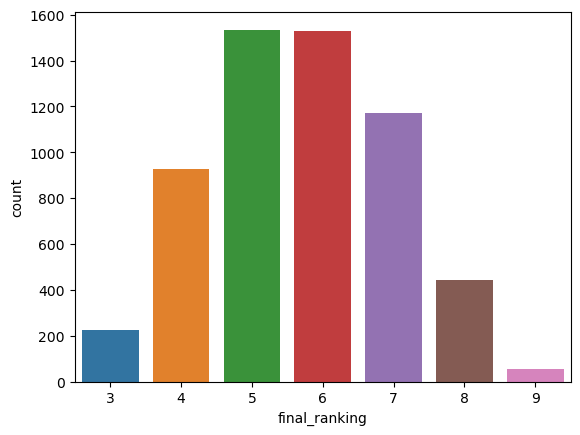

In [11]:
sns.countplot(data = final, x = final['final_ranking'])

## K-means Clustering

In [13]:
X = all_data[['recency', 'frequency', 'average_revenue']]
X

,recency,frequency,average_revenue
0,325,34,6463.038333
1,2,222,615.191250
2,75,51,403.880000
3,18,175,1107.172500
4,310,17,334.400000
...,...,...,...
5876,3,938,121.131818
5877,431,28,461.680000
5878,660,12,427.000000
5879,476,67,648.215000


In [14]:
model = KMeans(n_clusters = 3, n_init = 10, max_iter = 300, tol = 0.0001)

In [15]:
fitting = model.fit_predict(X)
fitting

array([2, 0, 0, ..., 0, 0, 0])

In [16]:
X['cluster'] = fitting
X['cluster'].value_counts()

C:\Users\thanh\AppData\Local\Temp\ipykernel_16932\2521633359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = fitting


cluster
0    5853
2      27
1       1
Name: count, dtype: int64

C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


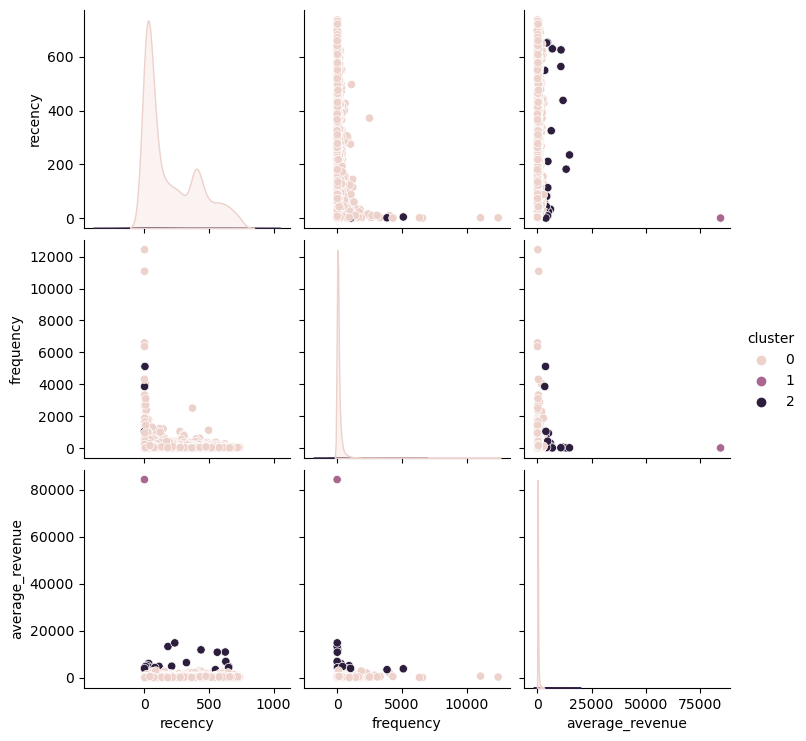

In [17]:
sns.pairplot(data = X, hue = 'cluster')

In [18]:
sse = []
for k in range(1,11):
    model = KMeans(n_clusters = k, n_init = 10, max_iter = 300, tol = 0.0001)
    result = model.fit(X)
    sse.append(result.inertia_)

sse

[9612311021.28059,
 2580021904.6090503,
 1708732491.2442114,
 1366029128.4908643,
 1043678476.849906,
 820739223.4459262,
 626794988.5706675,
 491663596.38249505,
 419148309.0430372,
 349109296.08765227]

C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

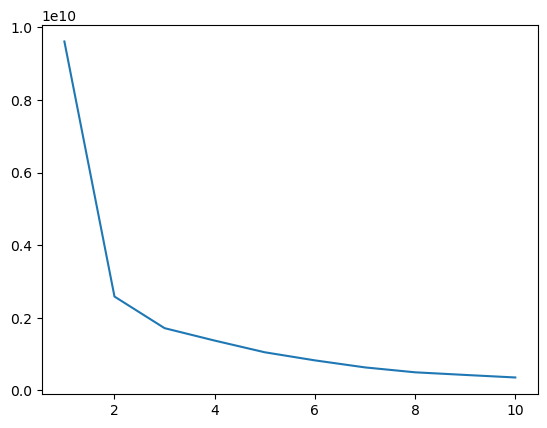

In [19]:
sns.lineplot(x = range(1,11), y = sse)

## Linear Regression, Lasso Regression, Decision Tree Regression, KNN Regression

In [21]:
retail_clean = pd.read_csv('retail_clean.csv')
retail_clean.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/2009 07:45,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/2009 07:45,6.75,13085,United Kingdom,81.0


In [22]:
retail_clean['InvoiceDate'] = pd.to_datetime(retail_clean['InvoiceDate'], format = '%d/%m/%Y %H:%M')
retail_clean['date'] = retail_clean['InvoiceDate'].dt.strftime('%d/%m/%Y')

In [23]:
retail_clean.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,01/12/2009
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,01/12/2009
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,01/12/2009


In [24]:
daily_revenue = retail_clean.groupby(by = ['date']).agg(total_revenue = ('Revenue', 'sum')).reset_index()
daily_revenue['date'] = pd.to_datetime(daily_revenue['date'], format = '%d/%m/%Y')
daily_revenue = daily_revenue.sort_values(by = 'date', ascending = True)

In [25]:
daily_revenue['month'] = daily_revenue['date'].dt.month
daily_revenue['month'] = daily_revenue['month'].astype('category')

daily_revenue['dayofweek'] = daily_revenue['date'].dt.dayofweek
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
daily_revenue['dayofweek'] = daily_revenue['dayofweek'].map(weekdays)

daily_revenue['trend'] = range(1,len(daily_revenue)+1)

In [26]:
daily_revenue

,date,total_revenue,month,dayofweek,trend
18,2009-12-01,43894.87,12,Tuesday,1
36,2009-12-02,52762.06,12,Wednesday,2
55,2009-12-03,67413.62,12,Thursday,3
76,2009-12-04,33913.81,12,Friday,4
95,2009-12-05,9803.05,12,Saturday,5
...,...,...,...,...,...
97,2011-12-05,58081.09,12,Monday,600
118,2011-12-06,45989.66,12,Tuesday,601
141,2011-12-07,69230.60,12,Wednesday,602
163,2011-12-08,50395.96,12,Thursday,603


In [27]:
daily_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Index: 604 entries, 18 to 184
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           604 non-null    datetime64[ns]
 1   total_revenue  604 non-null    float64       
 2   month          604 non-null    category      
 3   dayofweek      604 non-null    object        
 4   trend          604 non-null    int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 24.5+ KB


In [28]:
daily_revenue = pd.get_dummies(daily_revenue)

In [29]:
daily_revenue

,date,total_revenue,trend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,month_10,month_11,month_12,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
18,2009-12-01,43894.87,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
36,2009-12-02,52762.06,2,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
55,2009-12-03,67413.62,3,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
76,2009-12-04,33913.81,4,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
95,2009-12-05,9803.05,5,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2011-12-05,58081.09,600,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
118,2011-12-06,45989.66,601,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
141,2011-12-07,69230.60,602,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
163,2011-12-08,50395.96,603,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False


C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='total_revenue'>

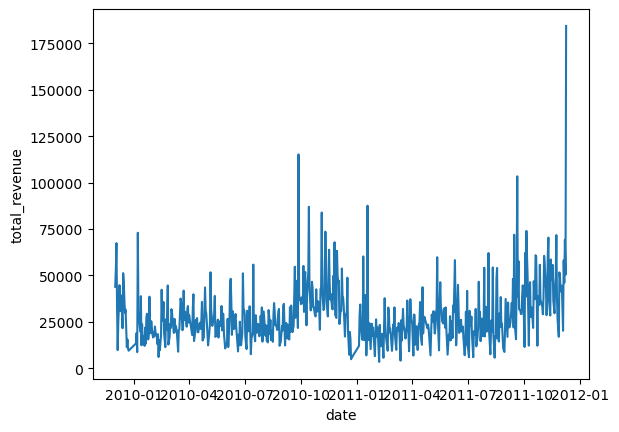

In [30]:
sns.lineplot(x = daily_revenue['date'], y = daily_revenue['total_revenue'])

In [31]:
X = daily_revenue.iloc[:, 2:]
y = daily_revenue['total_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [32]:
model_linear_regression = LinearRegression().fit(X_train, y_train)
model_lasso_regression = Lasso(alpha = 0.006, tol = 0.000001, max_iter = 1000).fit(X_train, y_train)
model_decision_tree = DecisionTreeRegressor().fit(X_train, y_train)
model_knn = KNeighborsRegressor(n_neighbors = 3).fit(X_train, y_train)

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.370e+09, tolerance: 8.592e+04
  model = cd_fast.enet_coordinate_descent(


In [33]:
model_linear_regression.score(X_train, y_train)

0.3796656758128836

In [34]:
model_lasso_regression.score(X_train, y_train)

0.3796656756822766

In [35]:
model_decision_tree.score(X_train, y_train)

1.0

In [36]:
model_knn.score(X_train, y_train)

0.5900015742912001

In [37]:
model_linear_regression.score(X_test, y_test)

0.11940207833647853

In [38]:
model_lasso_regression.score(X_test, y_test)

0.11940013949982808

In [39]:
model_decision_tree.score(X_test, y_test)

-0.5196014867746273

In [40]:
model_knn.score(X_test, y_test)

-0.06775884984147873

In [41]:
y_predict_linear = model_linear_regression.predict(X_test)
y_predict_lasso = model_lasso_regression.predict(X_test)
y_predict_tree = model_decision_tree.predict(X_test)
y_predict_knn = model_knn.predict(X_test)

In [42]:
mean_squared_error(y_test, y_predict_linear)

414852034.6177741

In [43]:
mean_squared_error(y_test, y_predict_lasso)

414852948.00890243

In [44]:
mean_squared_error(y_test, y_predict_tree)

715888322.1138577

In [45]:
mean_squared_error(y_test, y_predict_knn)

503024048.13888335

In [46]:
mean_absolute_error(y_test, y_predict_linear)

11604.045713869911

In [47]:
mean_absolute_error(y_test, y_predict_lasso)

11604.067506967065

In [48]:
mean_absolute_error(y_test, y_predict_tree)

15691.077512396696

In [49]:
mean_absolute_error(y_test, y_predict_knn)

15038.956614325069

## Tuning

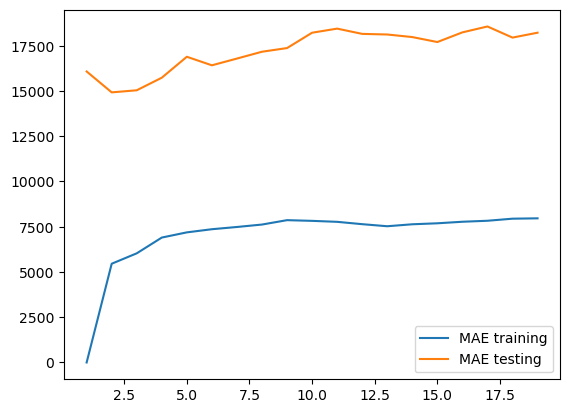

In [51]:
### Tuning KNN
MAE_training = []
MAE_testing = []
neighbor = range(1, 20)

for n in neighbor:
    model = KNeighborsRegressor(n_neighbors = n).fit(X_train, y_train)
    y_predict_training = model.predict(X_train)
    y_predict_testing = model.predict(X_test)
    training = mean_absolute_error(y_train, y_predict_training)
    testing = mean_absolute_error(y_test, y_predict_testing)
    MAE_training.append(training)
    MAE_testing.append(testing)

plt.plot(neighbor, MAE_training, label = 'MAE training')
plt.plot(neighbor, MAE_testing, label = 'MAE testing')
plt.legend()

C:\Users\thanh\AppData\Local\Temp\ipykernel_16932\1902610096.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model = Lasso(alpha = alpha).fit(X_train, y_train)
C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+10, tolerance: 8.592e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_co

,alpha,MAE training,MAE testing,scores
0,0.000000,7320.528005,11604.045714,0.379666
1,0.010101,7320.533597,11604.082403,0.379666
2,0.020202,7320.539189,11604.119091,0.379666
3,0.030303,7320.544780,11604.155780,0.379666
4,0.040404,7320.550372,11604.192469,0.379666
...,...,...,...,...
95,0.959596,7321.096513,11607.451675,0.379662
96,0.969697,7321.102363,11607.488770,0.379662
97,0.979798,7321.108376,11607.524355,0.379662
98,0.989899,7321.114361,11607.560200,0.379662


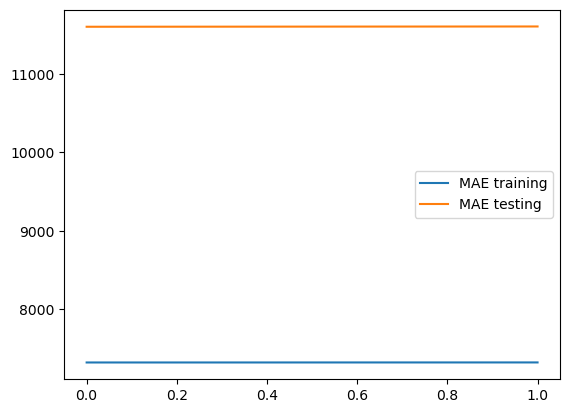

In [52]:
### Tuning Lasso
MAE_training = []
MAE_testing = []
model_scores = []

alphas = np.linspace(start = 0, stop = 1, num = 100)
for alpha in alphas:
    model = Lasso(alpha = alpha).fit(X_train, y_train)
    y_predict_training = model.predict(X_train)
    y_predict_testing = model.predict(X_test)
    scores = model.score(X_train, y_train)
    training = mean_absolute_error(y_train, y_predict_training)
    testing = mean_absolute_error(y_test, y_predict_testing)
    MAE_training.append(training)
    MAE_testing.append(testing)
    model_scores.append(scores)

alpha_data = pd.DataFrame({'alpha':alphas,
                           'MAE training':MAE_training,
                           'MAE testing':MAE_testing,
                           'scores':model_scores})

plt.plot(alphas, MAE_training, label = 'MAE training')
plt.plot(alphas, MAE_testing, label = 'MAE testing')
plt.legend()

alpha_data

In [53]:
alpha_data[alpha_data['scores'] == max(alpha_data['scores'])]

,alpha,MAE training,MAE testing,scores
0,0.0,7320.528005,11604.045714,0.379666


In [54]:
model_0 = Lasso(alpha = 0).fit(X_train, y_train)
model_0.coef_

C:\Users\thanh\AppData\Local\Temp\ipykernel_16932\2024106234.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_0 = Lasso(alpha = 0).fit(X_train, y_train)
C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+10, tolerance: 8.592e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coor

array([-5.00049254e+00, -6.29720498e+03, -9.78677870e+03, -5.85237927e+03,
       -5.87046235e+03, -2.84540058e+03, -4.37657912e+03, -6.92652783e+03,
       -6.21501467e+03,  2.18089151e+03,  1.08648459e+04,  1.54728403e+04,
        1.00983195e+03, -3.41451501e+03, -3.78903877e+02, -2.30782271e+04,
       -1.08710962e+04,  5.30422828e+03,  3.01378480e+03, -1.28541647e+03])

In [55]:
model_05 = Lasso(alpha = 0.5).fit(X_train, y_train)
model_05.coef_

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.810e+08, tolerance: 8.592e+06
  model = cd_fast.enet_coordinate_descent(


array([-4.99548368e+00, -2.67299818e+03, -6.16247390e+03, -2.22834638e+03,
       -2.24529507e+03,  7.69015345e+02, -7.52175718e+02, -3.30107984e+03,
       -2.58529122e+03,  5.79214822e+03,  1.44757369e+04,  1.90842007e+04,
        4.61911737e+03, -2.12607494e+03,  9.03138720e+02, -2.15390984e+04,
       -9.58255387e+03,  6.58659746e+03,  4.29620562e+03, -0.00000000e+00])

In [56]:
names = daily_revenue.drop(['date', 'total_revenue'], axis = 1).columns

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'trend'),
  Text(1, 0, 'month_1'),
  Text(2, 0, 'month_2'),
  Text(3, 0, 'month_3'),
  Text(4, 0, 'month_4'),
  Text(5, 0, 'month_5'),
  Text(6, 0, 'month_6'),
  Text(7, 0, 'month_7'),
  Text(8, 0, 'month_8'),
  Text(9, 0, 'month_9'),
  Text(10, 0, 'month_10'),
  Text(11, 0, 'month_11'),
  Text(12, 0, 'month_12'),
  Text(13, 0, 'dayofweek_Friday'),
  Text(14, 0, 'dayofweek_Monday'),
  Text(15, 0, 'dayofweek_Saturday'),
  Text(16, 0, 'dayofweek_Sunday'),
  Text(17, 0, 'dayofweek_Thursday'),
  Text(18, 0, 'dayofweek_Tuesday'),
  Text(19, 0, 'dayofweek_Wednesday')])

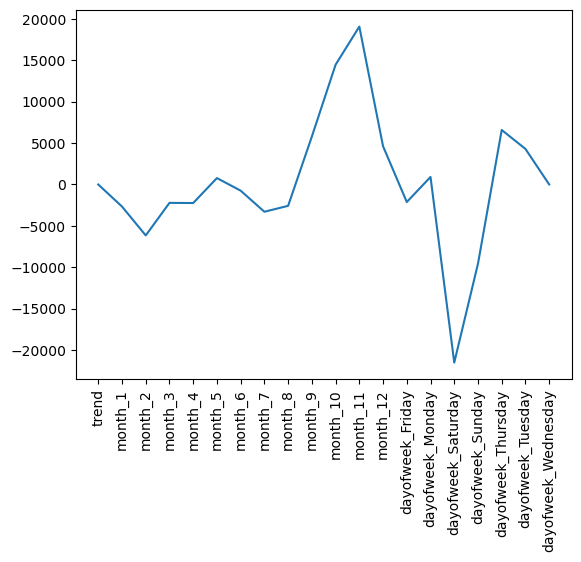

In [57]:
plt.plot(names, model_05.coef_)
plt.xticks(rotation = 90)

In [58]:
data_coef = pd.DataFrame({'name':names, 'coef':model_05.coef_})
data_coef

,name,coef
0,trend,-4.995484
1,month_1,-2672.998177
2,month_2,-6162.473897
3,month_3,-2228.346378
4,month_4,-2245.295067
5,month_5,769.015345
6,month_6,-752.175718
7,month_7,-3301.079838
8,month_8,-2585.291220
9,month_9,5792.148219


## Classification problem

In [60]:
banking = pd.read_csv('bank-full.csv')

In [61]:
banking.iloc[0, :]

age                  58
job          management
marital         married
education      tertiary
default              no
balance            2143
housing             yes
loan                 no
contact         unknown
day                   5
month               may
duration            261
campaign              1
pdays                -1
previous              0
poutcome        unknown
y                    no
Name: 0, dtype: object

In [62]:
banking['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [63]:
banking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\thanh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

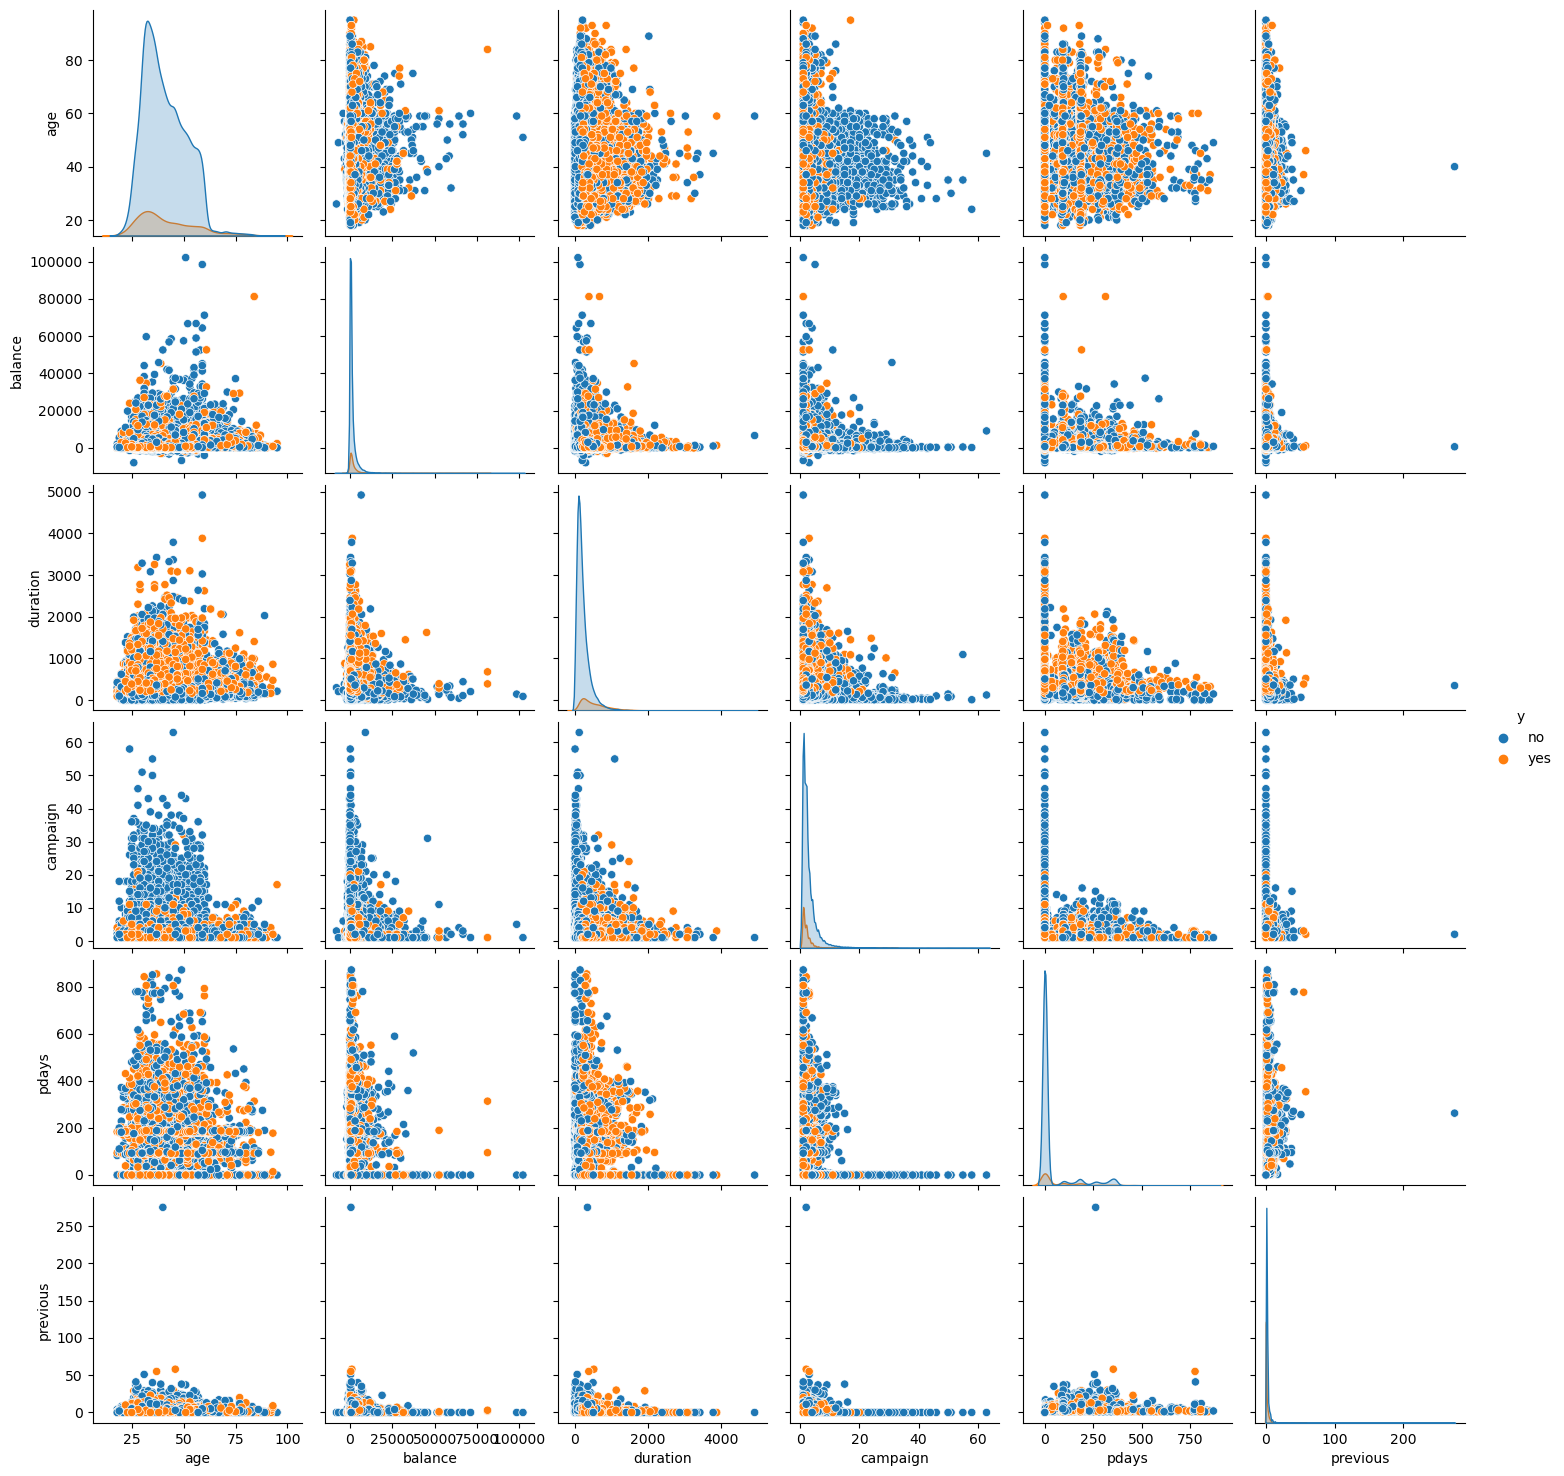

In [64]:
sns.pairplot(data = banking.iloc[:, [0,5,11,12,13,14,16]], hue = 'y')

In [65]:
banking.iloc[:, [0,5,11,12,13,14]].corr()

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.021560,-0.014578,0.003435,0.016674
duration,-0.004648,0.021560,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,0.001203,-0.032855,0.454820,1.000000


<Axes: >

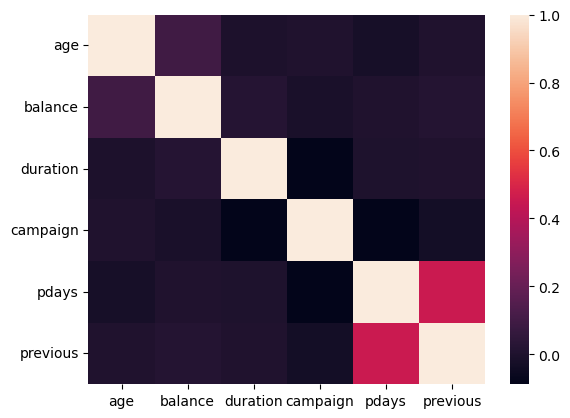

In [66]:
sns.heatmap(data = banking.iloc[:, [0,5,11,12,13,14]].corr())

In [67]:
dict_target = {'yes':1, 'no':0}
banking['target'] = banking['y'].map(dict_target)
banking['target'].value_counts()

target
0    39922
1     5289
Name: count, dtype: int64

In [68]:
banking.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
target       0
dtype: int64

In [69]:
banking.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
target       0
dtype: int64

In [70]:
banking = banking.drop('y', axis = 1)

In [71]:
y = banking['target'].values

In [72]:
X = banking.drop('target', axis = 1)
X = pd.get_dummies(X).values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [74]:
model_lr = LogisticRegression().fit(X_train, y_train)

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
model_lr.score(X_train, y_train)

0.8916445476664455

In [76]:
model_lr.score(X_test, y_test)

0.8935087913303107

In [77]:
banking.describe()

,age,balance,day,duration,campaign,pdays,previous,target
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [78]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)

MinMaxScaler()

In [79]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr.score(X_train, y_train)

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9011004202610042

In [81]:
model_lr.score(X_test, y_test)

0.9034612407386929

In [82]:
Cs = np.logspace(-8, 5, 20)

In [83]:
grid = dict({'C':Cs, 'penalty':['l1','l2']})

In [84]:
model_grid = LogisticRegression()
grid_fit = GridSearchCV(model_grid, grid, cv = 6)
grid_fit.fit(X_train, y_train)

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=6, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-08, 4.83293024e-08, 2.33572147e-07, 1.12883789e-06,
       5.45559478e-06, 2.63665090e-05, 1.27427499e-04, 6.15848211e-04,
       2.97635144e-03, 1.43844989e-02, 6.95192796e-02, 3.35981829e-01,
       1.62377674e+00, 7.84759970e+00, 3.79269019e+01, 1.83298071e+02,
       8.85866790e+02, 4.28133240e+03, 2.06913808e+04, 1.00000000e+05]),
                         'penalty': ['l1', 'l2']})

In [85]:
best_params = grid_fit.best_params_
best_params

{'C': 1.6237767391887243, 'penalty': 'l2'}

In [86]:
grid_fit.best_score_

0.9012110152621101

In [87]:
model = LogisticRegression(**best_params).fit(X_train, y_train)

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
y_predict = model.predict(X_test)

In [89]:
print(confusion_matrix(y_true = y_test, y_pred = y_predict))

[[7806  187]
 [ 685  365]]


In [90]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([7993, 1050], dtype=int64))

In [91]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_predict).ravel()

In [92]:
tn, fp, fn, tp

(7806, 187, 685, 365)

In [93]:
y_predicted_probability = model.predict_proba(X_test)
y_predicted_probability

array([[0.98311048, 0.01688952],
       [0.8583535 , 0.1416465 ],
       [0.9100192 , 0.0899808 ],
       ...,
       [0.93130465, 0.06869535],
       [0.76170235, 0.23829765],
       [0.92094898, 0.07905102]])

In [94]:
y_predicted_probability[:,1]

array([0.01688952, 0.1416465 , 0.0899808 , ..., 0.06869535, 0.23829765,
       0.07905102])

In [95]:
roc_auc_score(y_test, y_predicted_probability[:,1])

0.908629812991129

C:\Users\thanh\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

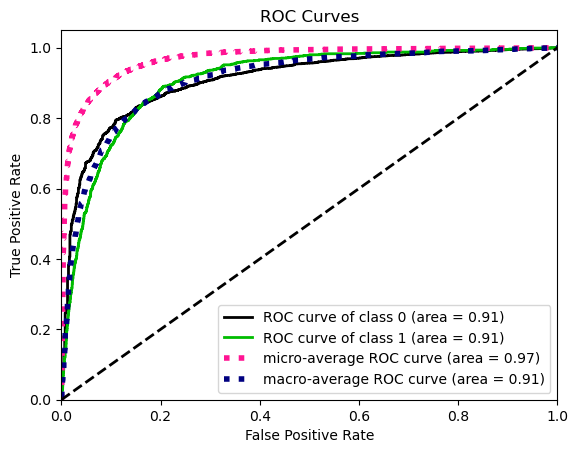

In [96]:
skplt.metrics.plot_roc_curve(y_test, model.predict_proba(X_test))

## Pipeline

In [98]:
p_lr = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()), 
    ('lr', LogisticRegression())])

p_rf = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())])

p_svc = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('svc', SVC())])

p_knn = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())])

In [99]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lr_range = np.logspace(-5, 5, 15)

grid_logistic = [{'lr__penalty':['l1','l2'], 
                  'lr__C':lr_range,
                  'lr__solver':['liblinear']}]

grid_rf = [{'rf__criterion': ['gini', 'entropy'],
            'rf__max_depth': [5],
            'rf__min_samples_leaf': param_range}]

grid_svc = [{'svc__kernel':['linear','rbf'], 
             'svc__C': param_range}]

grid_knn = [{'knn__n_neighbors': param_range}]

In [100]:
pipes = [p_lr, p_rf, p_svc, p_knn]
grids = [grid_logistic, grid_rf, grid_svc, grid_knn]

In [103]:
fitted_params = []
fitted_scores = []
fitted_roc = []

In [ ]:
for i in range(0, 4):
    model = GridSearchCV(estimator=pipes[i], param_grid=grids[i], cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_pred_prob)
    fitted_params.append(model.best_params_)
    fitted_scores.append(model.best_score_)
    fitted_roc.append(roc)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
